In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sys import path

path.insert(1, "/home/maxime/data/utils")
import myfunc as mf
import pandas as pd
import pyBigWig as pbw
from preprocess import default, subsample
import tensorflow as tf
CHR = "chr7"
labs = pbw.open("/home/maxime/data/mnase/labels/sparse_A_16.bw")
seq = mf.loadnp(f'/home/maxime/data/sequences/mm10/one_hot/{CHR}.npz')

2024-02-07 12:08:30.271797: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


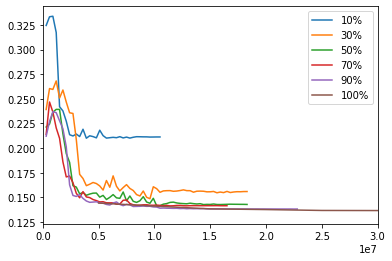

In [2]:
METRIC = "val_mae"
for i in range(1,12,2):
    if i==11:
        bin = 5000000
        df = pd.read_csv("/home/maxime/data/mnase/train/pred_sparse_A_16_ver1/history")
    else:
        bin = 300000
        df = pd.read_csv(f"/home/maxime/data/mnase/train/subsample/monitor_subsample_0{i}_ver0/history", index_col=[0])
        
    toplot = df[METRIC].values
    plt.plot((np.arange(len(toplot))*bin)+bin, toplot, label = f"{min(i*10, 100)}%")
    
plt.xlim(0, int(0.3e8))

plt.legend()


2024-02-07 12:08:49.053847: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-02-07 12:08:49.115044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-07 12:08:49.115197: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2024-02-07 12:08:49.115246: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-07 12:08:49.115367: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID

subsample to 70.0%
11680544
[1. 1. 1. ... 2. 1. 1.]


2024-02-07 12:09:36.594207: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 8004000000 exceeds 10% of free system memory.


subsample to 50.0%
11680544
[1. 1. 1. ... 2. 1. 1.]


2024-02-07 12:10:21.051036: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 8004000000 exceeds 10% of free system memory.


subsample to 30.0%
11680544
[1. 1. 1. ... 2. 1. 1.]


2024-02-07 12:11:05.588327: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 8004000000 exceeds 10% of free system memory.


subsample to 10.0%
11680544
[1. 1. 1. ... 2. 1. 1.]


2024-02-07 12:11:50.488664: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 8004000000 exceeds 10% of free system memory.


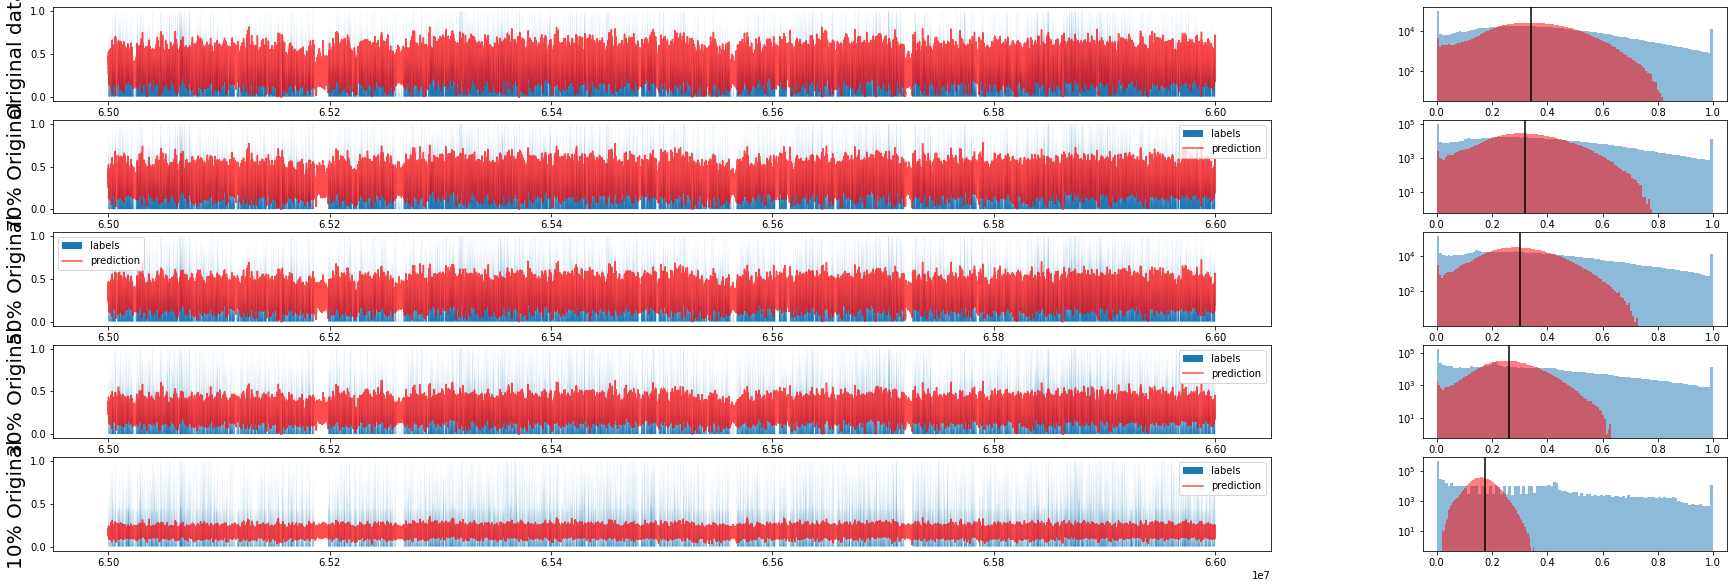

In [3]:
fig, axs = plt.subplots(5, 2, figsize = (30, 10), gridspec_kw={"width_ratios":[4, 1]}) #sharey=True, sharex=True
pos, l = int(0.65e8), 1_000_000

preds_cor = []
labs_cor = []

siglab = np.array(labs.values(CHR, 0, labs.chroms()[CHR]))
stmp = default(siglab)[pos:pos+l]
axs[0][0].fill_between(np.arange(pos, pos+l),  stmp)
model = tf.keras.models.load_model(f"/home/maxime/data/mnase/train/pred_sparse_A_16_ver1/best.h5", custom_objects={"mae_cor":None, "correlate":None})
preds = model.predict(mf.sliding_window_view(seq[pos-1000:pos+l+1000], (2001, 4)).reshape((-1, 2001, 4)), batch_size=1024)[:,2]
axs[0][0].plot(np.arange(pos, pos+l), preds, label="prediction", color = "r", alpha  = 0.7)
axs[0][0].set_ylabel("Original data", fontsize=20)

axs[0][1].hist(stmp, bins=100, alpha = 0.5)
axs[0][1].hist(preds, bins=100, alpha = 0.5, color = "r")
axs[0][1].axvline(np.mean(stmp), color = "k")
axs[0][1].set_yscale("log")
preds_cor.append(preds)
labs_cor.append(stmp)
for i, subs in enumerate(["07", "05", "03", "01"], 1):
    label_to_predict = subsample(siglab, float(f"{subs[0]}.{subs[1]}"))[pos:pos+l]
    axs[i][0].fill_between(np.arange(pos, pos+l),  label_to_predict, label = "labels")
    #01
    model = tf.keras.models.load_model(f"/home/maxime/data/mnase/train/subsample/monitor_subsample_{subs}_ver0/best.h5", custom_objects={"mae_cor":None, "correlate":None})
    preds = model.predict(mf.sliding_window_view(seq[pos-1000:pos+l+1000], (2001, 4)).reshape((-1, 2001, 4)), batch_size=1024)[:,2]
    axs[i][0].plot(np.arange(pos, pos+l), preds, label="prediction", color = "r", alpha  = 0.7)
    axs[i][0].legend()
    axs[i][0].set_ylabel(f"{int(subs)*10}% Original", fontsize = 20)
    
    axs[i][1].hist(label_to_predict, bins=100, alpha = 0.5)
    axs[i][1].hist(preds, bins=100, alpha = 0.5, color  = "r")
    axs[i][1].axvline(np.mean(label_to_predict), color = "k")
    axs[i][1].set_yscale("log")

    preds_cor.append(preds)
    labs_cor.append(label_to_predict)
    
corrs = np.vstack([preds_cor, labs_cor])

/tmp/ipykernel_45491/3914007572.py:7: RuntimeWarning: invalid value encountered in log
  return a/np.log(b*x) +c


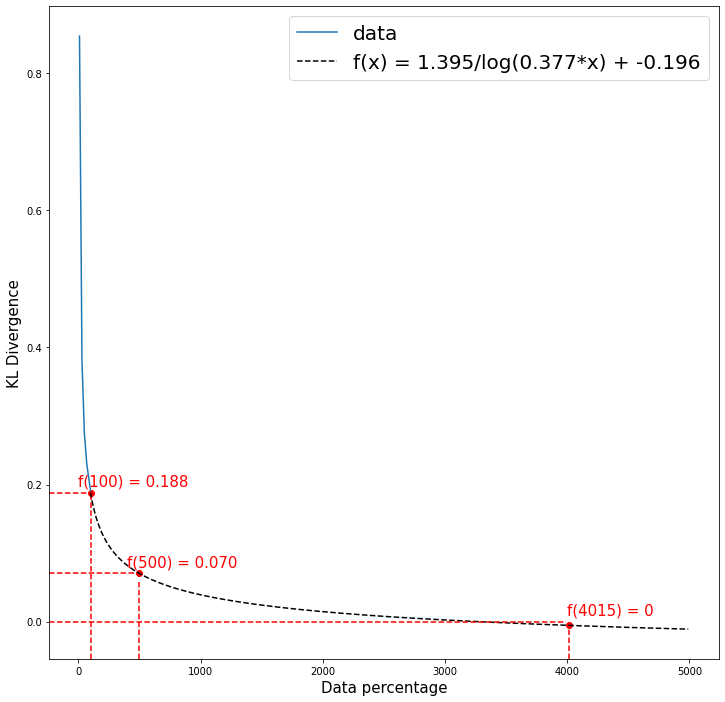

In [4]:
from scipy.stats import entropy
from scipy.optimize import curve_fit
def expfit(x, a, b):
    return a * np.exp(-b * x) 

def logfit(x, a, b, c):
    return a/np.log(b*x) +c
plt.figure(figsize = (12, 12))
dl = [entropy(labs_cor[i], preds_cor[i]) for i in range(5)]
x = np.array([100,70,50,30,10])
plt.plot(x, dl, label = "data")

x_t = np.arange(100,5000,10)

# exp_fitted = curve_fit(expfit, x, dl, np.array([1, 0.1]))
# plt.plot(x_t, expfit(x_t, *exp_fitted[0]), label = "fitted_exponnetialy")

log_fitted = curve_fit(logfit, x, dl, np.array([2, 1, -0.2]))
plt.plot(x_t, logfit(x_t, *log_fitted[0]), label = "f(x) = {:5.3f}/log({:5.3f}*x) + {:5.3f}".format(*log_fitted[0]), color = "k", linestyle="--")


an = 100
plt.axhline(logfit(an, *log_fitted[0]), xmin = 0, xmax = 0.06, color="r", linestyle="--")
plt.axvline(an, ymin = 0, ymax = logfit(an, *log_fitted[0])/0.76, color="r", linestyle="--")
plt.scatter(an, logfit(an, *log_fitted[0]), color = "r")
plt.annotate(f"f({an}) = {logfit(an, *log_fitted[0]):5.3f}", (an-100, logfit(an, *log_fitted[0])+0.01), fontsize = 15, color = "r")

an = 500
plt.axhline(logfit(an, *log_fitted[0]), xmin = 0, xmax = 0.13, color="r", linestyle="--")
plt.axvline(an, ymin = 0, ymax = logfit(an, *log_fitted[0])/0.6, color="r", linestyle="--")
plt.scatter(an, logfit(an, *log_fitted[0]), color = "r")
plt.annotate(f"f({an}) = {logfit(an, *log_fitted[0]):5.3f}", (an-100, logfit(an, *log_fitted[0])+0.01), fontsize = 15, color = "r")

plt.axhline(0, xmin = 0, xmax = 4015/5200, color="r", linestyle="--")
plt.axvline(4015, ymin = 0, ymax = 0.05, color="r", linestyle="--")
plt.scatter(4015, logfit(4015, *log_fitted[0]), color = "r")
plt.annotate("f(4015) = 0", (4000, 0.01), fontsize = 15, color = "r")



plt.ylabel("KL Divergence", fontsize = 15)
plt.xlabel("Data percentage", fontsize=15)
plt.legend(fontsize=20)


<AxesSubplot: >

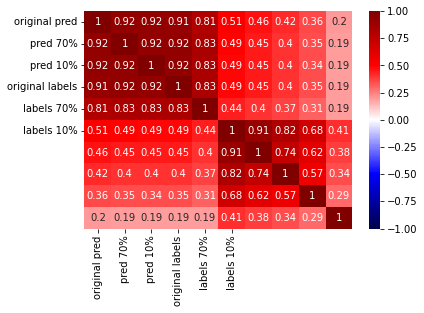

In [5]:
import seaborn as sns

labels = ["original pred", "pred 70%", "pred 10%", "original labels", "labels 70%", "labels 10%"]
sns.heatmap(np.corrcoef(corrs[:, labs_cor[-1]!=0]), annot = True, cmap = "seismic", vmin= -1, xticklabels=labels, yticklabels=labels)

<AxesSubplot: >

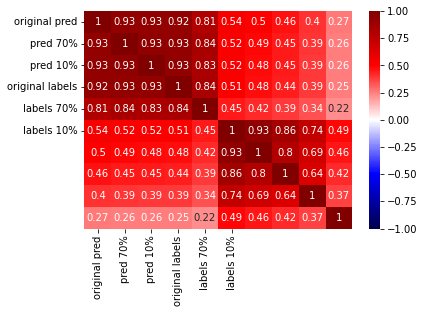

In [6]:
import seaborn as sns

labels = ["original pred", "pred 70%", "pred 10%", "original labels", "labels 70%", "labels 10%"]
sns.heatmap(np.corrcoef(corrs
                        ), annot = True, cmap = "seismic", vmin= -1, xticklabels=labels, yticklabels=labels)

NameError: name 'val_sub' is not defined

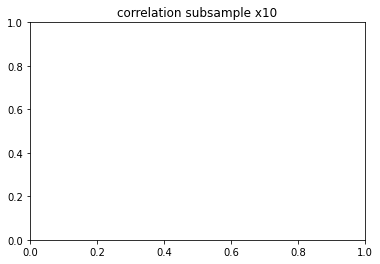

In [7]:
plt.title("correlation subsample x10")
plt.plot(val_sub, label = "validation")
plt.plot(sub.correlate, label = "training")
plt.legend()

In [ ]:
sub = pd.read_csv("/home/maxime/data/mnase/train/test_subsample01_ver2/history", index_col=[0])
val_sub = sub.correlate.values

original = pd.read_csv("/home/maxime/data/mnase/train/sparse_A_16_ver1/history", index_col=[0])
original_sub = original.correlate.values

plt.plot(original_sub, label = "original data")
plt.plot(val_sub, label = "x10 subsampled data ")
plt.plot()
plt.legend()
plt.title("Validation correlation")

In [ ]:
import numpy as np
import plotly.express as px

cor = np.corrcoef([np.arange(100_000_000), np.arange(100_000_000)])

px.imshow(cor, zmax=1, zmin=-1, color_continuous_scale="balance", text_auto=True)